# 22 : 378

In [1]:
import os, glob, pickle, time
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD


from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

import sys
path = os.path.abspath('../../')
print(path)
sys.path.append(path)
from CommonUtil import *

path = os.path.abspath('./models')
print(path)
sys.path.append(path)
import ResNet_1DCNN as res1d
import SE_ResNeXt_1DCNN as se_resx1d
import ResNeXt_1DCNN as resx1d
import Inception_ResNet_1DCNN as in_res1d

#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_VISIBLE_DEVICES"]='2'
# os.environ["CUDA_VISIBLE_DEVICES"]='2'
#mirrored_strategy = tf.distribute.MirroredStrategy()

/home/gil/gcubme_ai3/Workspace/SB_MUN
/home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/models


In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [3]:
LEARNING_RATE = 1e-4
EPOCHS = 200
BATCH_SIZE = 8
MODEL_NUM = 4
LOSS_FUNCTION = tf.keras.losses.MeanAbsoluteError()
LOSS_FUNCTION = 'binary_crossentropy'
METRICS = tf.keras.metrics.MeanSquaredError()
METRICS = ['accuracy']

TRAIN_SPLIT = 17

2024-01-13 18:19:42.998440: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-13 18:19:43.563114: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22325 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:86:00.0, compute capability: 8.6


In [4]:
length = 64000
model_name = 'ResNeXt'  # Modified DenseNet
model_width = 32  # Width of the Initial Layer, subsequent layers start from here
num_channel = 1  # Number of Channels in the Model
problem_type = 'Binary' # Classification or Regression
output_nums = 1  # Number of Class for Classification Problems, always '1' for Regression Problems
cardinality = 8
reduction_ratio = 4
# Build, Compile and Print Summary


In [5]:
DATA_PATH = os.path.abspath('./data/preproc2')
RESULT_DIR = os.path.abspath(f'./result/{model_name}')
MODEL_DIR = RESULT_DIR + '/model'

best_model_path = MODEL_DIR + '/best_model.h5'
model_path = MODEL_DIR + '/model.h5'

createFolder(MODEL_DIR)

print(DATA_PATH)
print(MODEL_DIR)

/home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/data/preproc2
/home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/ResNeXt/model


In [6]:
train_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/train/*.csv'))
validation_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/validation/*.csv'))

print(len(train_X_csv_list))
print(len(validation_X_csv_list))

20000
2500


In [7]:
train_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in train_X_csv_list]
train_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in train_X_csv_list]
validation_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in validation_X_csv_list]
validation_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in validation_X_csv_list]


In [8]:
train_X_npy_list, train_Y_npy_list = shuffle(train_X_npy_list, train_Y_npy_list)
validation_X_npy_list, validation_Y_npy_list = shuffle(validation_X_npy_list, validation_Y_npy_list)


In [9]:

def npy_load(X_path_list:list, Y_path_list:list):
    print(f'Total data len : {len(X_path_list)}')
    
    X_data = []
    Y_data = []
    data_paths = []
    
    for a in tqdm_notebook(range(len(X_path_list))):
#     for a in range(5):
        X_path = X_path_list[a]
        Y_path = Y_path_list[a]
    
#         print(f'{a}/{len(X_path_list)}\t==> {X_path}')
        
        X_npy = np.load(X_path)
        Y_npy = np.load(Y_path)
    
        X_data.extend(X_npy)
        Y_data.extend(Y_npy)
        data_paths.append(X_path)
        
    X_data, Y_data = shuffle(X_data, Y_data)
    
    X_data = np.array(X_data)
    Y_data = np.array(Y_data)
    X_data = np.expand_dims(X_data, axis=-1)
    Y_data = np.expand_dims(Y_data, axis=-1)
    print("X_data shape: ", X_data.shape, "\t Y_data shape: ", Y_data.shape)
    
    return X_data, Y_data # ,data_paths

In [10]:
train_X, train_Y = npy_load(train_X_npy_list, train_Y_npy_list)
validation_X, validation_Y = npy_load(validation_X_npy_list, validation_Y_npy_list)


Total data len : 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

X_data shape:  (37407, 64000, 1) 	 Y_data shape:  (37407, 1)
Total data len : 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

X_data shape:  (4801, 64000, 1) 	 Y_data shape:  (4801, 1)


In [11]:

print(list(train_Y).count(0))
print(list(train_Y).count(1))
print('='*50)
print(list(validation_Y).count(0))
print(list(validation_Y).count(1))
print('='*50)

24462
12945
2889
1912


# Model load

In [12]:
model = resx1d.ResNeXt(length, num_channel, model_width, cardinality=cardinality, problem_type=problem_type, \
                      output_nums=output_nums, pooling='max', dropout_rate=False).ResNeXt50()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), loss=LOSS_FUNCTION, metrics=METRICS)
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64000, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 32000, 32)    256         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32000, 32)    128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32000, 32)    0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, History, ReduceLROnPlateau, EarlyStopping

checkpointer = ModelCheckpoint(best_model_path, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, min_delta=1e-8)
earlystopper = EarlyStopping(monitor='val_loss', patience=30, verbose=1)
callbacks_list = [reduce_lr, checkpointer, earlystopper]

# train

In [14]:
from datetime import datetime
startTime = datetime.now()

print('Start Time : {0}'.format(startTime))
###############################################################################################

hist = model.fit(train_X, train_Y, 
                 batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1, 
                 validation_data = (validation_X, validation_Y), 
                 callbacks=callbacks_list)

################################################################################################

endTime = datetime.now()
runTime = endTime - startTime

print('End Time : {0}'.format(endTime))
print('Running Time : ' + str(runTime))

print('Done training')

Start Time : 2024-01-13 18:29:08.703410


2024-01-13 18:29:08.715456: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9576192000 exceeds 10% of free system memory.
2024-01-13 18:29:16.609835: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 9576192000 exceeds 10% of free system memory.
2024-01-13 18:29:22.239925: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/200


2024-01-13 18:30:09.000015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2024-01-13 18:30:11.601458: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


4676/4676 [==============================] - 2032s 424ms/step - loss: 0.6979 - accuracy: 0.7578 - val_loss: 0.6777 - val_accuracy: 0.6886

Epoch 00001: val_loss improved from inf to 0.67766, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/ResNeXt/model/best_model.h5


/data01/anaconda3/envs/mab_dental2/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/200
4676/4676 [==============================] - 1968s 421ms/step - loss: 0.2449 - accuracy: 0.9058 - val_loss: 0.4772 - val_accuracy: 0.7725

Epoch 00002: val_loss improved from 0.67766 to 0.47722, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/ResNeXt/model/best_model.h5
Epoch 3/200
4676/4676 [==============================] - 1967s 421ms/step - loss: 0.1882 - accuracy: 0.9282 - val_loss: 0.3559 - val_accuracy: 0.8448

Epoch 00003: val_loss improved from 0.47722 to 0.35592, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/ResNeXt/model/best_model.h5
Epoch 4/200
4676/4676 [==============================] - 1971s 422ms/step - loss: 0.1421 - accuracy: 0.9471 - val_loss: 0.2078 - val_accuracy: 0.9127

Epoch 00004: val_loss improved from 0.35592 to 0.20778, saving model to /home/gil/gcubme_ai3/Workspace/SB_MUN/9_NIA_46_dysarthria/1_source_abstract/result/ResNeXt/model/best_model.h

4676/4676 [==============================] - 1977s 423ms/step - loss: 0.0247 - accuracy: 0.9920 - val_loss: 0.0914 - val_accuracy: 0.9638

Epoch 00037: val_loss did not improve from 0.07043
Epoch 38/200
4676/4676 [==============================] - 1970s 421ms/step - loss: 0.0249 - accuracy: 0.9915 - val_loss: 0.0998 - val_accuracy: 0.9606

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.

Epoch 00038: val_loss did not improve from 0.07043
Epoch 39/200
4676/4676 [==============================] - 1966s 421ms/step - loss: 0.0261 - accuracy: 0.9917 - val_loss: 0.0977 - val_accuracy: 0.9615

Epoch 00039: val_loss did not improve from 0.07043
Epoch 40/200
4676/4676 [==============================] - 1968s 421ms/step - loss: 0.0255 - accuracy: 0.9913 - val_loss: 0.0939 - val_accuracy: 0.9635

Epoch 00040: val_loss did not improve from 0.07043
Epoch 41/200
4676/4676 [==============================] - 1964s 420ms/step - loss: 0.0254 - accuracy: 0.9917 - val_loss:

In [15]:
model.save(model_path)

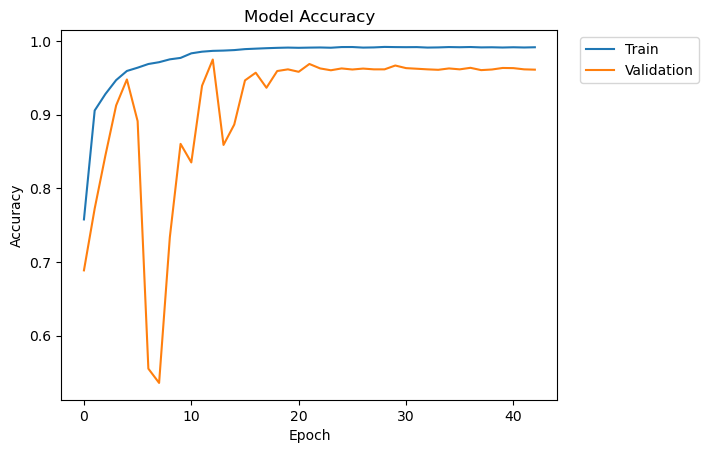

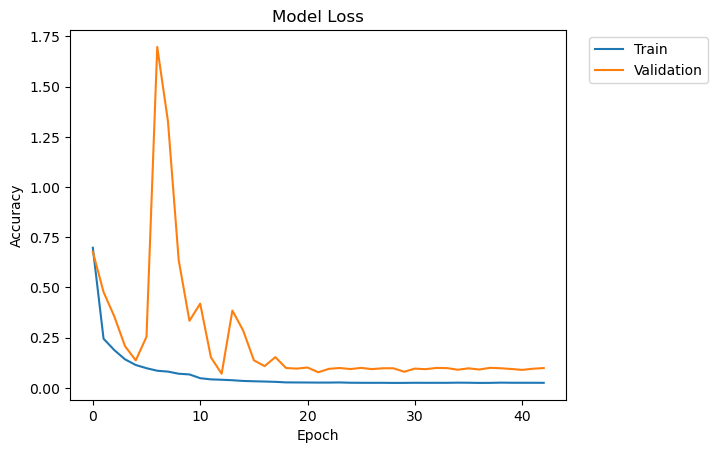

In [16]:
import matplotlib.pylab as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
# plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['val_loss'])
# plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right', bbox_to_anchor=(1.3, 1))
plt.show()

# test

In [17]:
test_X_csv_list = sorted(glob.glob(f'{DATA_PATH}/test/*.csv'))
print(len(test_X_csv_list))

test_X_npy_list = [csv_path.split('.csv')[0] + '_X.npy' for csv_path in test_X_csv_list]
test_Y_npy_list = [csv_path.split('.csv')[0] + '_Y.npy' for csv_path in test_X_csv_list]

test_X, test_Y = npy_load(test_X_npy_list, test_Y_npy_list)

2500
Total data len : 2500


  0%|          | 0/2500 [00:00<?, ?it/s]

X_data shape:  (4757, 64000, 1) 	 Y_data shape:  (4757, 1)


In [18]:
from keras.models import load_model

model = load_model(best_model_path)

In [19]:
predicted = model.predict(test_X, batch_size=64, verbose=1)

75/75 [==============================] - 56s 655ms/step


In [20]:
predict_Y = predicted > 0.5

In [21]:
print(list(predict_Y).count(0))
print(list(predict_Y).count(1))
print('='*50)
print(list(test_Y).count(0))
print(list(test_Y).count(1))


3072
1685
3087
1670


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.metrics import sensitivity_score, specificity_score

cm = confusion_matrix(test_Y, predict_Y)
sensitivity = sensitivity_score(test_Y, predict_Y)
specificity = specificity_score(test_Y, predict_Y)
accuracy = accuracy_score(test_Y, predict_Y)
precision = precision_score(test_Y, predict_Y)
f1 = f1_score(test_Y, predict_Y)

print(cm)
print(f'sensitivity : {round(sensitivity*100, 2)}')
print(f'specificity : {round(specificity*100, 2)}')
print(f'accuracy    : {round(accuracy*100, 2)}')
print(f'precision   : {round(precision*100, 2)}')
print(f'f1          : {round(f1*100, 2)}')


[[2966  121]
 [ 106 1564]]
sensitivity : 93.65
specificity : 96.08
accuracy    : 95.23
precision   : 92.82
f1          : 93.23


In [ ]:
# model = resx1d.ResNeXt(length, num_channel, model_width, cardinality=cardinality, problem_type=problem_type, \
#                       output_nums=output_nums, pooling='max', dropout_rate=False).ResNeXt50()